# Credit Card Customer Segmentation

A credit card company is looking for ways to target customers with relevant marketing strategies. To do this, we will use the k-means algorithm to make groups for customers with similar characteristics and suggest possible strategies. Then the credit card company can apply the marketing strategy tailored to each group.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# read in data
customers = pd.read_csv('customer_segmentation.csv')
customers.head()

# setting visualization style
sns.set_style('whitegrid')

### Exploratory Data Analysis

In [2]:
# view column information
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

The customer segmentation dataset has 14 columns and 10127 observations with no missing values. Below is an explanation of the columns in the dataset.

Categorical columns:
- gender
- education_level
- marital_status

Numeric columns:
- age: customer age in years
- dependent_count: how many dependents the customer has
- estimated_income: estimated annual income
- months_on_book: how many months they have been a customer
- total_relationship_count: how many times the customer contacted the company
- months_inactive_12_mon: how many months the customer did not use the card in the last year
- credit_limit: credit limit for that customer
- total_trans_amount: total amount of money spent with the card
- total_trans_count: total number of times the card was used
- avg_utilization_ratio: daily average balance on the card

In [3]:
# view statistics of the dataset
customers.describe()

,customer_id,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,62078.206774,35.928409,3.812580,2.341167,8631.953698,4404.086304,64.858695,0.274894
std,3.690378e+07,8.016814,1.298908,39372.861291,7.986416,1.554408,1.010622,9088.776650,3397.129254,23.472570,0.275691
min,7.080821e+08,26.000000,0.000000,20000.000000,13.000000,1.000000,0.000000,1438.300000,510.000000,10.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,32000.000000,31.000000,3.000000,2.000000,2555.000000,2155.500000,45.000000,0.023000
50%,7.179264e+08,46.000000,2.000000,50000.000000,36.000000,4.000000,2.000000,4549.000000,3899.000000,67.000000,0.176000
75%,7.731435e+08,52.000000,3.000000,80000.000000,40.000000,5.000000,3.000000,11067.500000,4741.000000,81.000000,0.503000
max,8.283431e+08,73.000000,5.000000,200000.000000,56.000000,6.000000,6.000000,34516.000000,18484.000000,139.000000,0.999000


Next we'll examine our categorical columns to see the possible values and their frequencies, then check for correlations between variables.

In [4]:
cat_cols = ['gender', 'education_level', 'marital_status']
for col in cat_cols:
    print(customers[col].value_counts(), end='\n\n')

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: count, dtype: int64

marital_status
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64



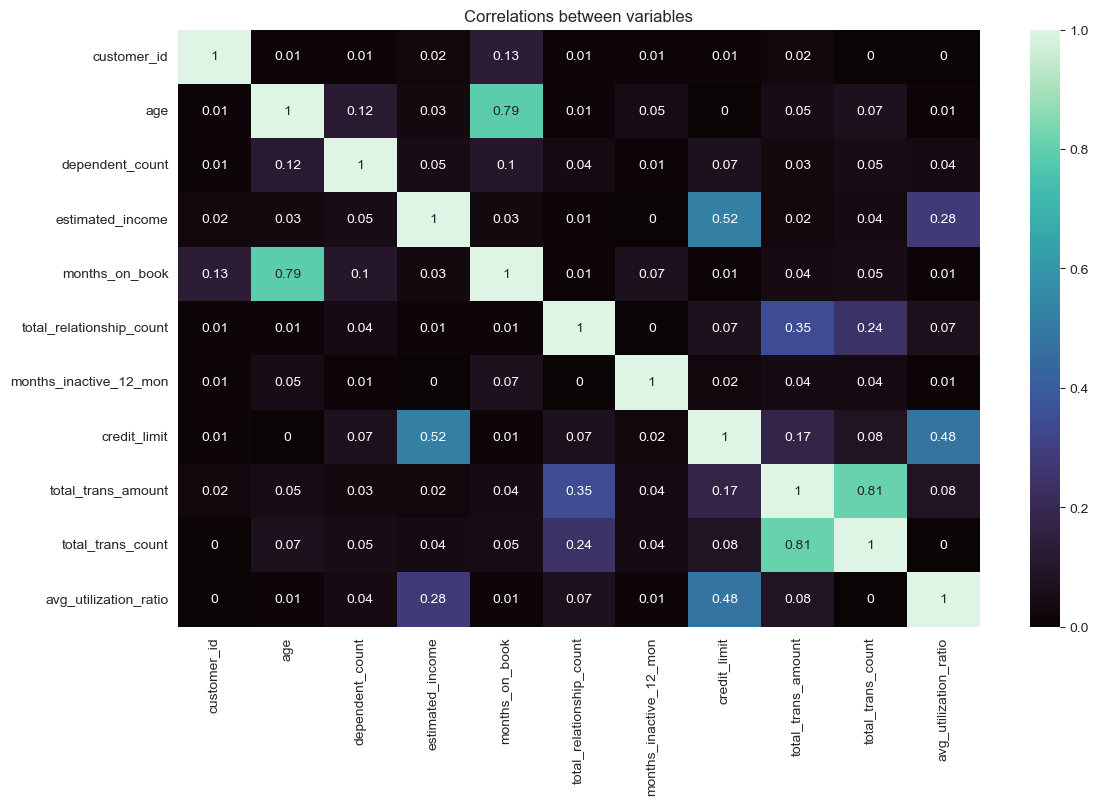

In [5]:
# Check to see what variables are most strongly correlated using Pearson's heat map
correlations = abs(customers.drop(cat_cols, axis=1).corr())
plt.figure(figsize=(12,8))
sns.heatmap(round(correlations, 2), annot=True, cmap='mako')
plt.tight_layout()
plt.title('Correlations Between Variables')
plt.show()

There are a few pairs with strong correlations:
- age and months on book
- estimated income and credit limit
- total trans amount and total trans count
- credit limit and avg utilization ratio

### Feature Engineering

Next we will make a copy of the dataframe and modify the non-numeric columns: gender, education level, marital status. For gender, since there are only two values we can assign them to 0 and 1. For education, we can rank them from uneducated as the lowest to doctorate as the highest. Since we can't rank marital status, we will use one-hot-coding to create dummy variables.

In [6]:
# create copy so original dataframe remains unchanged
customers_modif = customers.copy()

# update gender column using 0 for female and 1 for male
customers_modif['gender'] = customers_modif['gender'].apply(lambda x: 1 if x=='M' else 0)

# update education column
education = {
    'Uneducated' : 0,
    'High School' : 1,
    'College' : 2,
    'Graduate' : 3,
    'Post-Graduate' : 4,
    'Doctorate' : 5
    }

customers_modif['education_level'] = customers_modif['education_level'].map(education)

# create dummy variables for marital status
customers_modif = pd.get_dummies(data=customers_modif, columns=['marital_status'], drop_first=True)

# view changes
customers_modif.head()

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,True,False,False
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,False,True,False
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,True,False,False
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,False,False,True
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,True,False,False


### Scaling data

Now that we've dealt with categorical columns, it's time to standardize the dataset. The size of different variables ranges from 5 or less to hundreds of thousands, so we'll put them all on the same scale to more effectively compare them.

In [7]:
# create new dataframe without customer_id column
customers_no_id = customers_modif.drop('customer_id', axis=1)

# create instance of scaler, fit the scaler, and transform the data
scaler = StandardScaler()
scaler.fit(customers_no_id)
customers_scaled = scaler.transform(customers_no_id)
print(customers_scaled[:5])

X = pd.DataFrame(customers_scaled)

[[-0.16540558  1.05995565  0.50336813 -0.75221102  0.1758098   0.38462088
   0.76394261 -1.32713603  0.4466219  -0.95970657 -0.97389518 -0.77588223
   1.07733799 -0.79850685 -0.28260887]
 [ 0.33357038 -0.9434357   2.04319867  0.66278684 -0.96716585  1.01071482
   1.40730617 -1.32713603 -0.04136665 -0.91643261 -1.35734038 -0.61627565
  -0.92821381  1.2523374  -0.28260887]
 [ 0.58305837  1.05995565  0.50336813  0.66278684  0.78539682  0.00896451
   0.12057905 -1.32713603 -0.5736978  -0.74098169 -1.91120566 -0.99715499
   1.07733799 -0.79850685 -0.28260887]
 [-0.78912553 -0.9434357   1.2732834  -0.75221102 -0.63697289 -0.24147306
  -0.52278451  1.64147829 -0.58525108 -0.95175829 -1.91120566  1.75968594
  -0.92821381 -0.79850685  3.53845931]
 [-0.78912553  1.05995565  0.50336813 -1.45970995  0.07421197 -1.86931731
   0.76394261 -1.32713603 -0.43087725 -1.05626345 -1.57036549 -0.99715499
   1.07733799 -0.79850685 -0.28260887]]


### Choosing K

Before we can create our K-means model, we have to decide on the number of clusters to use. We'll create models from different k values, compute the inertia, then plot an elbow curve to find the best value for k.

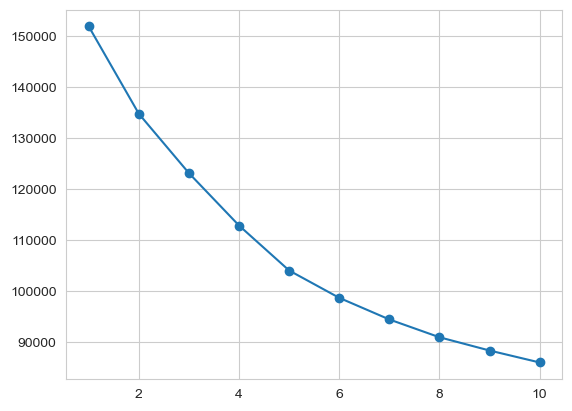

In [8]:
# empty list for inertias
inertias = []

# loop through values of k and add inertia to the list
for k in range(1,11):
    model = KMeans(n_clusters=k, random_state=1, n_init=10)
    cluster = model.fit_predict(X)
    inertias.append(model.inertia_)
    
# plot elbow curve
plt.plot(range(1,11), inertias, marker='o')
plt.show()

There is no distinct turning point, but the elbow of the curve is from 5 to 7 where the decrease slows. We will select 6 since it is in the middle of the three.

In [9]:
# instantiate new Kmeans object with 6 clusters
model = KMeans(n_clusters=6, random_state=1, n_init=10)
cluster = model.fit_predict(X)
print(cluster)

[4 1 4 ... 3 2 3]


### Analyzing results

In order to analyze our results, we will assign the calculated clusters to the customers and see what information we can gleen from them. We will look at bar plots of numeric variables, scatterplots of correlated variables, and percent distribution for categorical columns.

In [10]:
# add 1, since cluser values currently range from 0-5 but we want them labeled as 1-6
customers['cluster'] = cluster + 1
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,cluster
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,5
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,2
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,5
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,3
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,4


In [11]:
# view how many customers belong to each cluster
customers['cluster'].value_counts()

cluster
4    2795
2    2482
5    1785
6    1418
1     913
3     734
Name: count, dtype: int64

Cluster 4 has the most customers, and cluster 3 has the least customers. Next  we will take a look at the numeric characteristics of different clusters using bar charts.

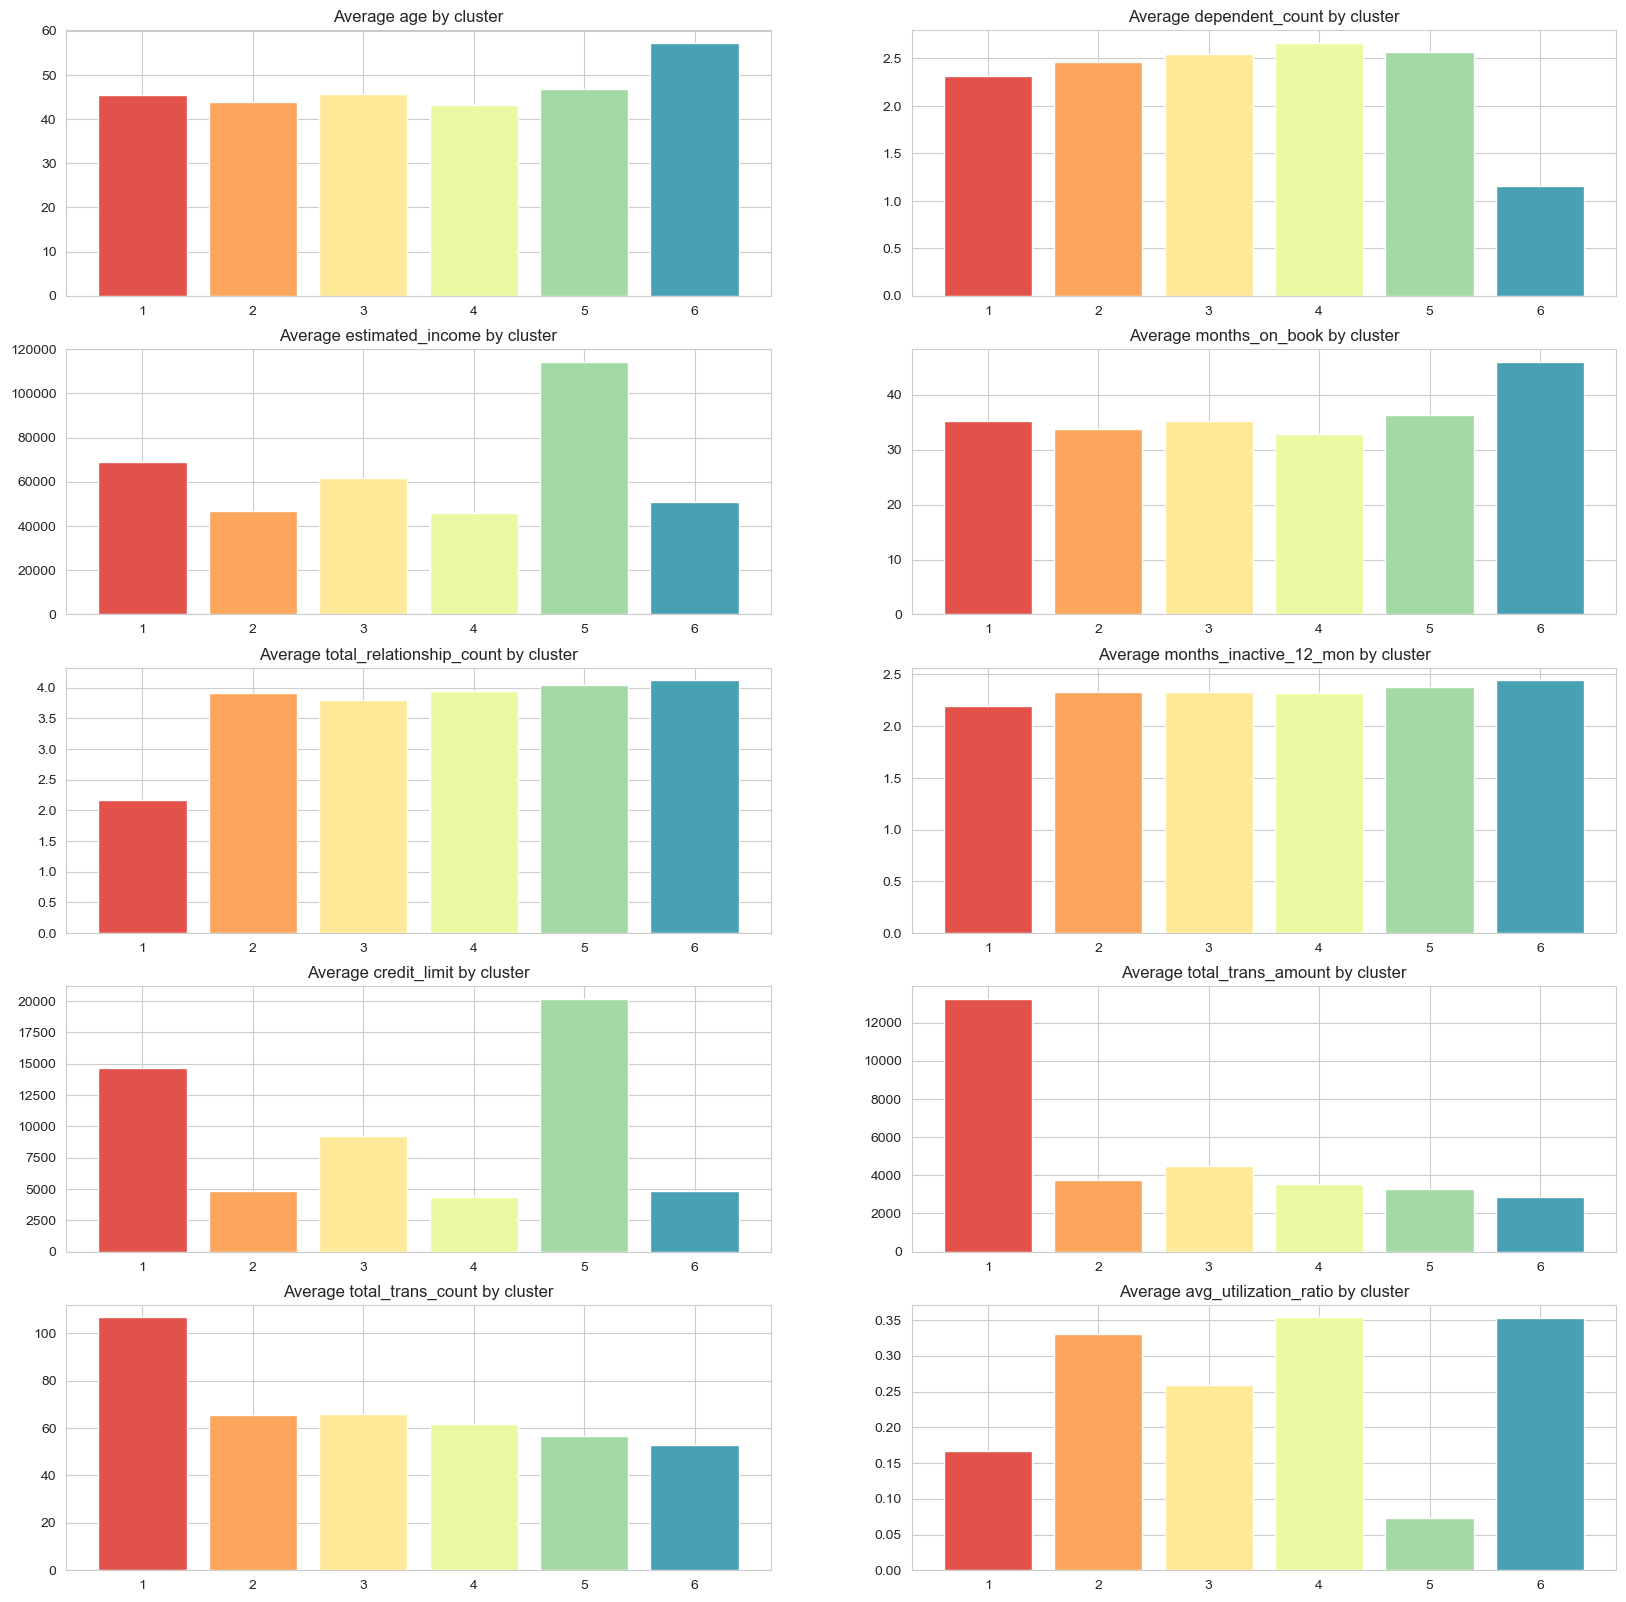

In [12]:
# plot bar charts for the numeric variables, grouped by cluster
numeric_cols = ['age', 'dependent_count', 'estimated_income', 'months_on_book', 'total_relationship_count', 
                'months_inactive_12_mon', 'credit_limit', 'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio']

fig = plt.figure(figsize=(20, 20))

for i, col in enumerate(numeric_cols):
    averages = customers.groupby('cluster')[col].mean()
    ax=fig.add_subplot(5, 2, i+1)
    ax.bar(averages.index, averages, color=sns.color_palette('Spectral'))
    ax.set_title(f'Average {col} by cluster')

plt.show()

Cluster 6 has the highest age and months on books and lowest dependent counts. Cluster 5 has the highest income and credit limit but lowest utilization. Cluster 1 has the lowest relationship counts and the highest transaction amounts and counts. Months inactive were fairly even for all clusters. <br><br>

Now we'll look at the relationship between the variable pairs noted earlier.

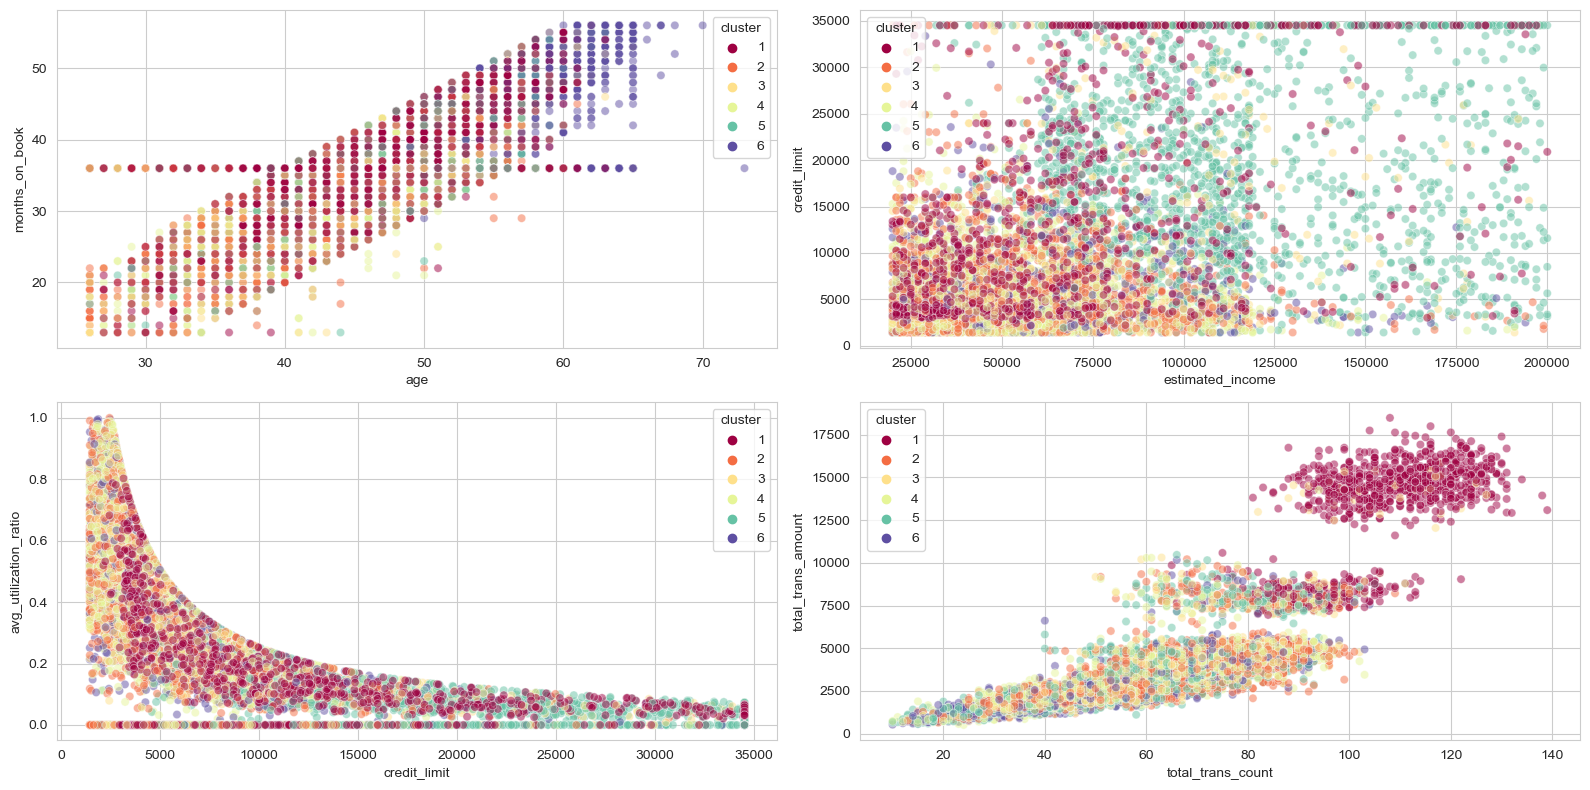

In [13]:
# scatterplots for the variable pairs with high correlation
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='age', y='months_on_book', hue='cluster', data=customers, palette='Spectral', alpha=0.5, ax=ax1)
sns.scatterplot(x='estimated_income', y='credit_limit', hue='cluster', data=customers, palette='Spectral', alpha=0.5, ax=ax2)
sns.scatterplot(x='credit_limit', y='avg_utilization_ratio', hue='cluster', data=customers, palette='Spectral', alpha=0.5, ax=ax3)
sns.scatterplot(x='total_trans_count', y='total_trans_amount', hue='cluster', data=customers, palette='Spectral', alpha=0.5, ax=ax4)

plt.tight_layout()
plt.show()


Now we'll look at the categorical columns to see the proportions for each cluster.

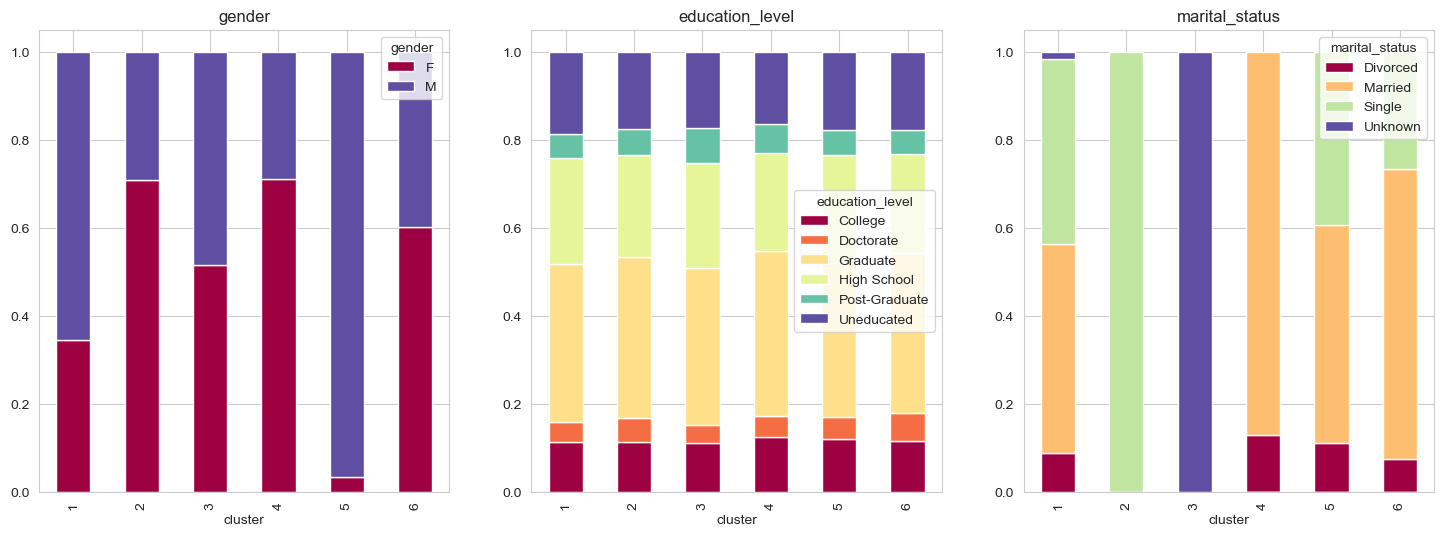

In [16]:
# stacked bar chart for categorical columns

fig = plt.figure(figsize=(18, 6))
for i, col in enumerate(cat_cols):
    cross = pd.crosstab(index=customers['cluster'], columns=customers[col], values=customers[col], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
    cross.plot.bar(stacked=True, ax=ax, cmap='Spectral')
    ax.set_title(col)
    
plt.show()

Cluster 5 is almost entirely male. Education level is even across all clusters. Everyone in cluster 3 is of unknown marital status, everyone in cluster 2 is single, and almost everyone in cluster 4 is married.

### Conclusion

Each customer now belongs to a cluster, and we can examine the characteristics of each cluster and make our recommendations. Here is what we have found: <br><br>

Cluster 1:
- low relationship count
- high credit limit and transaction values
- low utilization ratio
- Insight - people who use the card frequently and for large purchases but are still able to mostly pay off their balance. They could be given a higher credit limit or be encouraged to use the card for small everyday purchases.


Cluster 2:
- low income and credit limit
- high utilization ratio
- single
- Insight - low income individuals who are not paying off their cards. If they have cards at other financial institutions, they might be convinced to transfer balances and use just this card.

Cluster 3:
- moderate income and credit limit
- moderate utilization ratio
- unknown marital status
- Insight - this group is very average in most ways. It could be targeted as 'the everyday person'.

Cluster 4:
- low income and credit limit
- high utilization ratio
- mostly married
- Insight - mostly low income families who are not paying off their cards. Could be encouraged to pay bills and existing expenses with the card instead of other payment methods.

Cluster 5:
- high income and credit limit
- low utilization ratio
- mostly men
- Insight - mostly high-earning men with families. Could be incentivised to buy more with the card, or could recommend they get a joint credit card for their dependents.

Cluster 6:
- high age and months on books
- low dependent count and transaction values
- high utilization ratio
- Insight - older individuals who have been customers for a long time and are not supporting families. They are likely inclined to use cash, but could be encouraged to use the card instead. They would probably appreciate rewards for loyal customers.

Now that we've determined the characteristics of our different groups, and potential strategies for them, we can see what groups each customer falls into, allowing us to target them for relevant marketing. We will put this information into a csv file that can be sent to management.

In [15]:
# The customers and the clusters they belong to
customers[['customer_id', 'cluster']]

,customer_id,cluster
0,768805383,5
1,818770008,2
2,713982108,5
3,769911858,3
4,709106358,4
...,...,...
10122,772366833,1
10123,710638233,4
10124,716506083,4
10125,717406983,3


In [17]:
# output dataframe to csv file
customers.to_csv('Customer segmentation results')